In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import time

In [2]:
import numpy as np
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist

Using Theano backend.


In [3]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
nb_epoch = 50
epsilon_std = 0.01

In [4]:
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [5]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., std=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [6]:
#  TensorFlowがバックエンドの場合、"output_shape"は必要ない。
# `Lambda(sampling)([z_mean, z_log_var])`と書く
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [7]:
# 再利用のために別々にインスタンス化
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [8]:
'''
def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss
'''

'\ndef vae_loss(x, x_decoded_mean):\n    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)\n    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)\n    return xent_loss + kl_loss\n'

In [11]:
def binary_crossentropy(y_true, y_pred):
    return K.sum(K.binary_crossentropy(y_pred, y_true), axis=-1)
 
def vae_loss(x, x_decoded_mean):
    reconst_loss = K.mean(binary_crossentropy(x, x_decoded_mean),axis=-1)
    latent_loss =  - 0.5 * K.mean(K.sum(1 + K.log(K.square(z_log_var)) - K.square(z_mean) - K.square(z_log_var), axis=-1))
    return reconst_loss + latent_loss

In [12]:
vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)

In [13]:
from keras.utils.visualize_util import plot
plot(vae, to_file="vae.png", show_shapes=True)

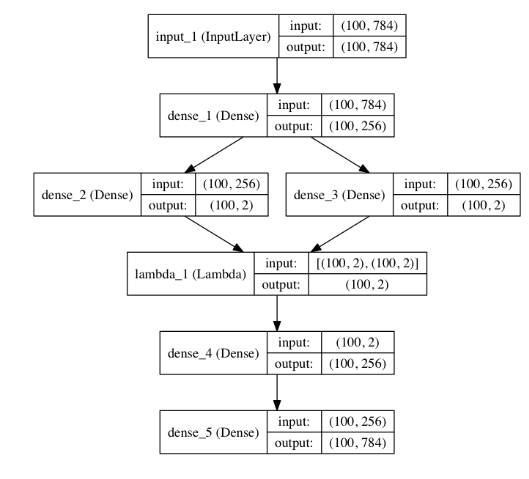

In [14]:
from PIL import Image

plt.figure(figsize=(10, 8))
im = Image.open("vae.png", "r")
plt.imshow(np.array(im))
plt.axis('off')
plt.show()

In [15]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [16]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [17]:
vae.fit(x_train, x_train, 
            shuffle=True,
            nb_epoch=nb_epoch,
            batch_size=batch_size,
            validation_data=(x_test, x_test))
time.sleep(0.1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 11s - loss: 185.0745 - val_loss: 166.3661
Epoch 2/50
60000/60000 [==============================] - 12s - loss: 164.0555 - val_loss: 162.4073
Epoch 3/50
60000/60000 [==============================] - 14s - loss: 160.7236 - val_loss: 159.9959
Epoch 4/50
60000/60000 [==============================] - 16s - loss: 158.4968 - val_loss: 158.0180
Epoch 5/50
60000/60000 [==============================] - 16s - loss: 156.7185 - val_loss: 156.2727
Epoch 6/50
60000/60000 [==============================] - 17s - loss: 155.0743 - val_loss: 154.8908
Epoch 7/50
60000/60000 [==============================] - 17s - loss: 153.6581 - val_loss: 153.5405
Epoch 8/50
60000/60000 [==============================] - 17s - loss: 152.5158 - val_loss: 152.7804
Epoch 9/50
60000/60000 [==============================] - 17s - loss: 151.6040 - val_loss: 151.7732
Epoch 10/50
60000/60000 [=========================

In [18]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

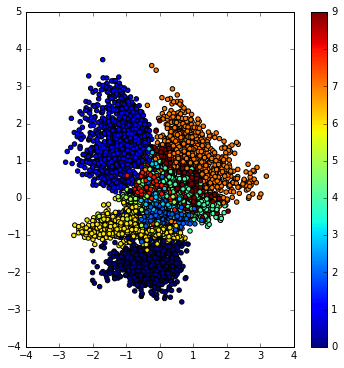

In [19]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [20]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

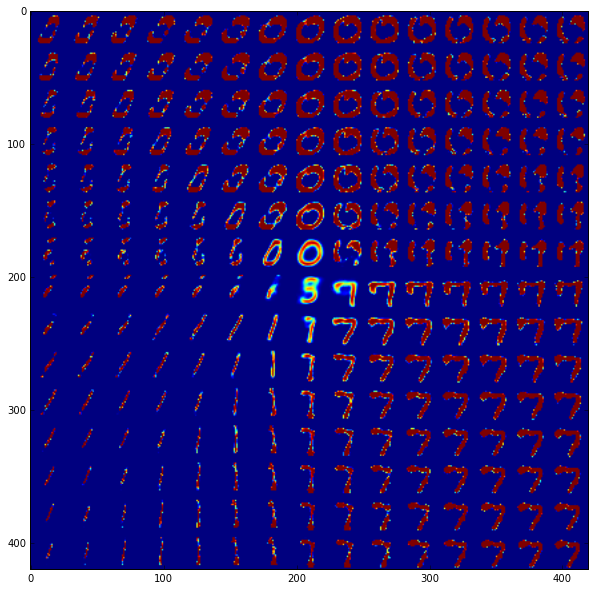

In [21]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

In [22]:
ae_object =vae.history

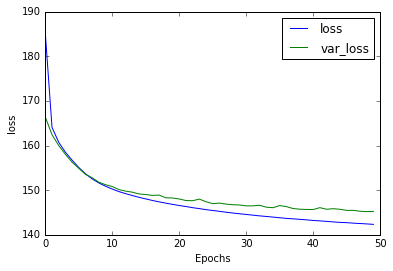

In [23]:
plt.figure(figsize=(6, 4))
plt.plot(range(len(ae_object.epoch)), ae_object.history['loss'], label='loss')
plt.plot(range(len(ae_object.epoch)), ae_object.history['val_loss'], label='var_loss')
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend(loc="upper right")
plt.show()

In [24]:
vae.save_weights('vae.h5')